100%|██████████| 89617/89617 [1:41:18<00:00, 14.74it/s]  


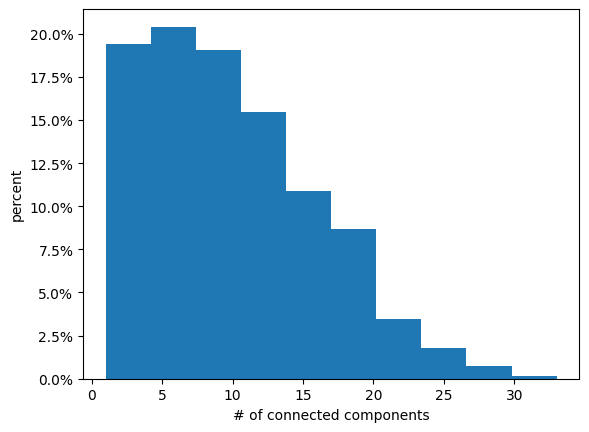

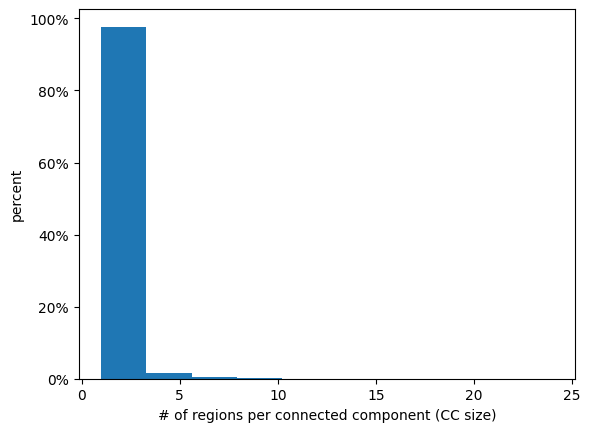

In [3]:
import json
import os
from tqdm import tqdm
final_json_path = '/home/ngzhili/uoais/datasets/syntable/train/uoais_train.json'
import numpy as np
import glob

import os
import cv2
import glob
import numpy as np
import imageio
import torch

from tqdm import tqdm

from detectron2.engine import DefaultPredictor
from adet.config import get_cfg
from adet.utils.post_process import detector_postprocess, DefaultPredictor

from utils import normalize_depth, inpaint_depth, standardize_image, array_to_tensor
from foreground_segmentation.model import Context_Guided_Network
from termcolor import colored
import matplotlib.pyplot as plt
import networkx as nx
def compute_occluded_masks(mask1, mask2):
    """Computes occlusions between two sets of masks.
    masks1, masks2: [Height, Width, instances]
    """

    # intersections and union
    mask1_area = np.count_nonzero(mask1)
    mask2_area = np.count_nonzero(mask2)
    intersection_mask = np.logical_and(mask1, mask2)
    intersection = np.count_nonzero(np.logical_and(mask1, mask2))

    iou = intersection/(mask1_area+mask2_area-intersection)

    return iou, intersection_mask.astype(float)

# A(i,j), col j, row i. row i --> col j
def generate_ooam(inst_vis_mask_list,occlusion_mask_list):
    rows = cols = len(inst_vis_mask_list)
    ooam = np.zeros((rows,cols))
    for i in range(0,len(inst_vis_mask_list)):
        visible_mask_i = inst_vis_mask_list[i] # occluder
        for j in range(0,len(occlusion_mask_list)):
            if j != i:
                occluded_mask_j = occlusion_mask_list[j] # occludee
                iou, _ = compute_occluded_masks(visible_mask_i,occluded_mask_j) 
                
                if iou > 0.1: # object i's visible mask is overlapping object j's occluded mask
                    # print(iou)
                    # print(np.count_nonzero(_))
                    ooam[i][j] = 1
    return ooam
def find_num_cc_dataset(final_json_path):
    f = open(final_json_path)
    data = json.load(f)
    f.close()

    num_connected_component_list = []
    size_of_connected_component_list = []
    amodal_area = 0
    occ_area = 0
    ooc_instances = 0
    occlusion_rate_list = []
    # query_img_id = [49,53]
    import pycocotools.mask as mask_util

    curr_anno = []
    cur_img_id = data["annotations"][0]["image_id"]

    for i in tqdm(range(len(data["annotations"]))):
        ann = data["annotations"][i]

        if i == len(data["annotations"]) - 1:
            curr_anno.append(ann)
            img_info = data["images"][i]

            # print(curr_anno)
            inst_vis_mask_list = []
            occlusion_mask_list = []
            for image_anno in curr_anno:
                segm = image_anno["visible_mask"]
                visible_mask = mask_util.decode(segm)
                inst_vis_mask_list.append(visible_mask)

                segm = image_anno["occluded_mask"]
                occ_mask = mask_util.decode(segm)
                occlusion_mask_list.append(occ_mask)

            gt_ooam = generate_ooam(inst_vis_mask_list,occlusion_mask_list)

            """ === Generate Directed Graph === """
            # print("Occlusion Order Adjacency Matrix:\n",occlusion_order_adjacency_matrix)
            # f, (ax1,ax2) = plt.subplots(1,2)
            # show_graph_with_labels(overlap_adjacency_matrix,ax1)
            labels = [i for i in range(1,len(gt_ooam)+1)]
            labels_dict = {}
            for i in range(len(gt_ooam)):
                labels_dict.update({i:labels[i]})
            
            rows, cols = np.where(gt_ooam == 1)
            rows += 1
            cols += 1
            edges = zip(rows.tolist(), cols.tolist())
            nodes_list = [i for i in range(1, len(gt_ooam)+1)]
            # Initialise directed graph G
            G = nx.DiGraph()
            G.add_nodes_from(nodes_list)
            G.add_edges_from(edges)
            
            # pos=nx.spring_layout(G,k=1/sqrt(N))
            # pos=nx.planar_layout(G)

            # print("Nodes:",G.nodes())
            # print("Edges:",G.edges())
            # print(G.in_edges())
            # print(G.out_edges())
            # get start nodes
            start_nodes = [node for (node,degree) in G.in_degree if degree == 0]
            # print("start_nodes:",start_nodes)
            # get end nodes
            end_nodes = [node for (node,degree) in G.out_degree if degree == 0]
            for node in end_nodes:
                if node in start_nodes:
                    end_nodes.remove(node)
            # print("end_nodes:",end_nodes)
            # get intermediate notes
            intermediate_nodes = [i for i in nodes_list if i not in (start_nodes) and i not in (end_nodes)]
            # print("intermediate_nodes:",intermediate_nodes)

            # print("(Degree of clustering) Number of Weakly Connected Components:",nx.number_weakly_connected_components(G))
            # largest_wcc = max(nx.weakly_connected_components(G), key=len)
            # largest_wcc_size = len(largest_wcc)
            # print("(Scene Complexity) Sizes of Weakly Connected Component:",largest_wcc_size)
            
            wcc_list = list(nx.weakly_connected_components(G))
            # scc_list = list(nx.strongly_connected_components(G))
            # cc_list = list(nx.connected_components(G))
            # wcc_len = []
            # for component in wcc_list:
                # wcc_len.append(len(component))

            # print("(Scene Complexity/Degree of overlapping regions) Sizes of Weakly Connected Components:",wcc_len)

            for component in wcc_list:
                size_of_connected_component_list.append(len(component))
            # for component in scc_list:
            #     num_components += len(component)

            num_connected_component_list.append(len(wcc_list))

        elif ann["image_id"] == cur_img_id:
            curr_anno.append(ann)
            img_info = data["images"][i]

            inst_vis_mask_list = []
            occlusion_mask_list = []
            for image_anno in curr_anno:
                segm = image_anno["visible_mask"]
                visible_mask = mask_util.decode(segm)
                inst_vis_mask_list.append(visible_mask)

                segm = image_anno["occluded_mask"]
                occ_mask = mask_util.decode(segm)
                occlusion_mask_list.append(occ_mask)

            gt_ooam = generate_ooam(inst_vis_mask_list,occlusion_mask_list)

            """ === Generate Directed Graph === """
            # print("Occlusion Order Adjacency Matrix:\n",occlusion_order_adjacency_matrix)
            # f, (ax1,ax2) = plt.subplots(1,2)
            # show_graph_with_labels(overlap_adjacency_matrix,ax1)
            # labels = [i for i in range(1,len(gt_ooam)+1)]
            # labels_dict = {}
            # for i in range(len(gt_ooam)):
            #     labels_dict.update({i:labels[i]})
            
            rows, cols = np.where(gt_ooam == 1)
            rows += 1
            cols += 1
            edges = zip(rows.tolist(), cols.tolist())
            nodes_list = [i for i in range(1, len(gt_ooam)+1)]
            # Initialise directed graph G
            G = nx.DiGraph()
            G.add_nodes_from(nodes_list)
            G.add_edges_from(edges)
            
            # pos=nx.spring_layout(G,k=1/sqrt(N))
            # pos=nx.planar_layout(G)

            # print("Nodes:",G.nodes())
            # print("Edges:",G.edges())
            # print(G.in_edges())
            # print(G.out_edges())
            # get start nodes
            # start_nodes = [node for (node,degree) in G.in_degree if degree == 0]
            # # print("start_nodes:",start_nodes)
            # # get end nodes
            # end_nodes = [node for (node,degree) in G.out_degree if degree == 0]
            # for node in end_nodes:
            #     if node in start_nodes:
            #         end_nodes.remove(node)
            # # print("end_nodes:",end_nodes)
            # # get intermediate notes
            # intermediate_nodes = [i for i in nodes_list if i not in (start_nodes) and i not in (end_nodes)]
            # print("intermediate_nodes:",intermediate_nodes)

            # print("(Degree of clustering) Number of Weakly Connected Components:",nx.number_weakly_connected_components(G))
            # largest_wcc = max(nx.weakly_connected_components(G), key=len)
            # largest_wcc_size = len(largest_wcc)
            # print("(Scene Complexity) Sizes of Weakly Connected Component:",largest_wcc_size)
            
            wcc_list = list(nx.weakly_connected_components(G))
            # scc_list = list(nx.strongly_connected_components(G))
            # cc_list = list(nx.connected_components(G))
            # wcc_len = []
            # for component in wcc_list:
                # wcc_len.append(len(component))

            # print("(Scene Complexity/Degree of overlapping regions) Sizes of Weakly Connected Components:",wcc_len)
            for component in wcc_list:
                size_of_connected_component_list.append(len(component))
            # for component in scc_list:
            #     num_components += len(component)

            num_connected_component_list.append(len(wcc_list))


            continue
        # image_id = ann["image_id"]
        # if image_id < query_img_id[0]:
        #     continue

        # if image_id > query_img_id[1]:
        #     break
        
        # ann_id = ann["id"]
        # print(image_id)
        segm = ann["visible_mask"]
        visible_mask = mask_util.decode(segm)

        # segm = ann["segmentation"]
        # amodal_mask = mask_util.decode(segm)

        segm = ann["occluded_mask"]
        occ_mask = mask_util.decode(segm)

        # amodal_area += np.count_nonzero(amodal_mask)
        # occ_area += np.count_nonzero(occ_mask)
        # occlusion_rate = np.count_nonzero(occ_mask)/np.count_nonzero(amodal_mask)
        # occlusion_rate_list.append(occlusion_rate)
        

        curr_anno = []
        curr_anno.append(ann)
        cur_img_id = ann["image_id"]

    # occlusion_rate = occ_area/amodal_area
    # return  amodal_area, occ_area, occlusion_rate, ooc_instances
    return num_connected_component_list, size_of_connected_component_list


def plot_histogram_size_cc(data):
    def bins_labels(bins, **kwargs):
        bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
        plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
        plt.xlim(bins[0], bins[-1])
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import PercentFormatter

    bins = 10
    plt.hist(data, weights=np.ones(len(data)) / len(data),rwidth=1, bins=bins,align='mid')

    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    # plt.hist(data,bins=bins,align='mid')

    plt.xlabel("# of regions per connected component (CC size)")
    plt.ylabel("percent")

    plt.show()

def plot_histogram_num_cc(data):
    def bins_labels(bins, **kwargs):
        bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
        plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
        plt.xlim(bins[0], bins[-1])
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import PercentFormatter

    bins = 10
    plt.hist(data, weights=np.ones(len(data)) / len(data),rwidth=1, bins=bins,align='mid')

    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    # plt.hist(data,bins=bins,align='mid')

    plt.xlabel("# of connected components")
    plt.ylabel("percent")

    plt.show()


final_json_path = '/home/ngzhili/uoais/datasets/syntable/validation/uoais_val.json'
num_connected_component_list, size_of_connected_component_list = find_num_cc_dataset(final_json_path)
plot_histogram_num_cc(num_connected_component_list)

plot_histogram_size_cc(size_of_connected_component_list)